# Probability and fitting tuning curves

1. Oriented gratings
2. Spikes as poisson process
    * counting process
    * rate
    * count probability as a function of rate
3. Conditional probability
    * rate conditional on time
    * rate conditional on stimulus
4. Receptive field
    * tuning location in space
    * tuning for orientation

## Coding of stimuli in primary visual cortex

Since [1959](https://doi.org/10.1113/jphysiol.1959.sp006308) it has been known that neurons in the primary visual cortex respond to moving lines in the visual field. It was a chance observation by Hubel and Wiesel (accidentally knocking a projector), that lead them to identify the space of stimuli that optimally drive neuronal responses in primary visual cortex. They found that when a bar of light moved across a specific area of the visual field, it would elicit single unit spiking when it occurred at a particular angle. The further it rotated away from that angle, the less of a response was elicited. 

![HubelWiesel1959](./images/HubelWiesel1959.png)

While bars of a light can be easily generated and their properties modified, modern visual physiologists use *drifting gratings*, which can be loosely thought of as a series of white bars moving across a black background. These stimuli were used extensively in the Allen Institute data we downloaded to characterize the responses of neurons visual stimuli. To see what they look like, check out this [link](https://observatory.brain-map.org/visualcoding/stimulus/drifting_gratings). 

Drifting gratings are generally characterized by three parameters:

1. Orientation: This is the direction the bars are moving, and varies from 0-360 degrees. Orientation sensitivity is one of the most well studied features of neural coding for drifting gratings. In general, neurons respond preferentially to a specific orientation, with the response fading out when you get more than >30 degrees away from the preferred orientation. 
2. Spatial frequency: The width of the bars. The wider the bars are, the lower the spatial frequency. The narrower the bars are, the higher the spatial frequency. Neurons tend to have a preferred spatial frequency.
3. Temporal frequency: How fast are the bars moving across the visual field. A higher frequency means the bars are drifting faster. Neurons tend to have a preferred temporal frequency. 
4. Contrast: Is the degree to which the black and white lines of the deviate from gray, the contrast can be varied. Neurons in V1 typically respond was increasing vigor as the contrast is raised. 

The data we will work with was collected while mice viewed a wide variety of stimuli, including many drifting gratings. According to their [white paper](https://portal.brain-map.org/explore/circuits/visual-coding-neuropixels), they all had the same contrast (80%) and spatial frequency (0.04 cycles/degree), but varied in their orientation (0-315 in 45 degree increments), and temporal frequency (1, 2, 4, 8, and 15 Hz). We can verify this by loading the stimulus list used in the session we will analyze today.

First, let's import the packages we will need.

In [28]:
import os
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from source.utils import spikes_to_df

Then we have to create the session object that can access the data.

In [2]:
# initialize data cache
allen_dir = ['..','data','spike_allen']
manifest_path = os.path.join(*allen_dir,'manifest.json')
cache = EcephysProjectCache(manifest=manifest_path)

# get session
sess_id = 750332458
sess = cache.get_session_data(sess_id, filter_by_validity=False)

# get the ids of the units that passed quality control last week
# save as an numpy file where the Allen cache is stored
ids_path = os.path.join(*allen_dir,'clean_unit_ids.npy')
unit_ids = np.load(ids_path)

/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/drewheadley/anaconda3/envs/decode_brain/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


The session object contains a dataframe with all the stimuli that were presented.

In [3]:
stims = sess.stimulus_presentations
stims.head()

,stimulus_block,start_time,stop_time,stimulus_name,x_position,contrast,size,temporal_frequency,orientation,color,spatial_frequency,frame,y_position,phase,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
0,null,24.343718,84.410468,spontaneous,null,null,null,null,null,null,null,null,null,null,60.066750,0
1,0.0,84.410468,84.643989,gabors,0.0,0.8,"[20.0, 20.0]",4.0,90.0,null,0.08,null,20.0,"[3644.93333333, 3644.93333333]",0.233521,1
2,0.0,84.643989,84.894190,gabors,20.0,0.8,"[20.0, 20.0]",4.0,90.0,null,0.08,null,-10.0,"[3644.93333333, 3644.93333333]",0.250201,2
3,0.0,84.894190,85.144391,gabors,-30.0,0.8,"[20.0, 20.0]",4.0,45.0,null,0.08,null,-10.0,"[3644.93333333, 3644.93333333]",0.250201,3
4,0.0,85.144391,85.394592,gabors,40.0,0.8,"[20.0, 20.0]",4.0,0.0,null,0.08,null,30.0,"[3644.93333333, 3644.93333333]",0.250201,4


Each presented stimulus has an assortment of information associated with it. We are particularly interested in extracting the drifting grating stimuli, so we will filter the dataframe to just have those.

In [4]:
dg_stims = stims[stims['stimulus_name'] == 'drifting_gratings']
dg_stims.head()

,stimulus_block,start_time,stop_time,stimulus_name,x_position,contrast,size,temporal_frequency,orientation,color,spatial_frequency,frame,y_position,phase,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
3798,2.0,1585.647748,1587.649398,drifting_gratings,null,0.8,"[250.0, 250.0]",4.0,180.0,null,0.04,null,null,"[21235.93333333, 21235.93333333]",2.00165,246
3799,2.0,1588.650242,1590.651902,drifting_gratings,null,0.8,"[250.0, 250.0]",4.0,225.0,null,0.04,null,null,"[21235.93333333, 21235.93333333]",2.00166,247
3800,2.0,1591.652728,1593.654418,drifting_gratings,null,0.8,"[250.0, 250.0]",2.0,135.0,null,0.04,null,null,"[21235.93333333, 21235.93333333]",2.00169,248
3801,2.0,1594.655252,1596.656912,drifting_gratings,null,0.8,"[250.0, 250.0]",2.0,0.0,null,0.04,null,null,"[21235.93333333, 21235.93333333]",2.00166,249
3802,2.0,1597.657758,1599.659418,drifting_gratings,null,0.8,"[250.0, 250.0]",15.0,315.0,null,0.04,null,null,"[21235.93333333, 21235.93333333]",2.00166,250


Now let's confirm that the contrast, spatial frequencies, orientations, and temporal frequencies match those in the white paper.

In [5]:
# list the contrasts
contrasts = dg_stims['contrast'].unique()
print('Contrasts used:',contrasts)

# list the spatial frequencies
sfs = dg_stims['spatial_frequency'].unique()
print('Spatial frequencies used:',sfs)

# list the orientations
orientations = dg_stims['orientation'].unique()
print('Orientations used:',orientations)

# list the temporal frequencies
tfs = dg_stims['temporal_frequency'].unique()
print('Temporal frequencies used:',tfs)


Contrasts used: [0.8 'null']
Spatial frequencies used: ['0.04' 'null']
Orientations used: [180.0 225.0 135.0 0.0 315.0 90.0 270.0 'null' 45.0]
Temporal frequencies used: [4.0 2.0 15.0 8.0 1.0 'null']


Looks like they agree. The only problem is that some stimuli have a 'null' tag for those parameters. Let's get rid of the drifting grating where their parameters were 'null'.

In [6]:
# remove nulls
dg_stims = dg_stims[(dg_stims['contrast']!='null') |
                    (dg_stims['spatial_frequency']!='null') |
                    (dg_stims['orientation']!='null') |
                    (dg_stims['temporal_frequency']!='null')]

Having removed the nulls, we can now count the how many of each trial type was present. According to the white paper there should be 15 trials for each drifting grating variant.

In [7]:
dg_stim_counts = dg_stims.groupby(['contrast', 'spatial_frequency', 'orientation', 'temporal_frequency']).size()
print('Number of trials for each unique stimulus:')
print(dg_stim_counts)

Number of trials for each unique stimulus:
contrast  spatial_frequency  orientation  temporal_frequency
0.8       0.04               0.0          1.0                   15
                                          2.0                   15
                                          4.0                   15
                                          8.0                   15
                                          15.0                  15
                             45.0         1.0                   15
                                          2.0                   15
                                          4.0                   15
                                          8.0                   15
                                          15.0                  15
                             90.0         1.0                   15
                                          2.0                   15
                                          4.0                   15
                         

Great, 15 of each type. According to the white paper, drifting gratings were presented in 3 blocks. Each stimulus was given for 2 seconds (*stimulus duration*), with 1 second between the stopping of a stimulus and the presentation of the next one (known as the *inter-stimulus interval*). Let's confirm this before analyzing spiking activity with respect to stimuli.

Text(0.5, 1.0, 'Drifting gratings presentation times')

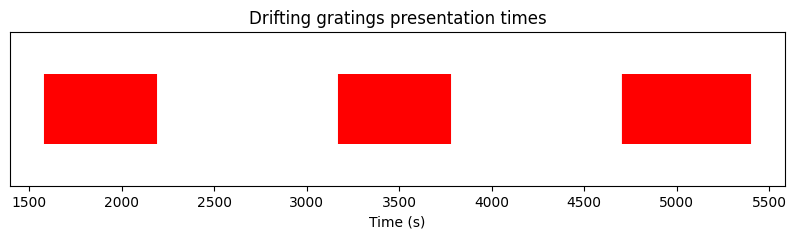

In [8]:
# get all times when drifting gratings were presented
dg_times = dg_stims['start_time'].values
dg_blocks = dg_stims['stimulus_block'].values

# plot the times when drifting gratings were presented
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.eventplot(dg_times, color='red')
ax.set_xlabel('Time (s)')
ax.set_yticks([])
ax.set_title('Drifting gratings presentation times')

Here we can see the three blocks when stimuli were presented. Next we will get the duration of stimuli.

Median duration: 2.0016700000005585


Text(0.5, 1.0, 'Histogram of drifting gratings durations')

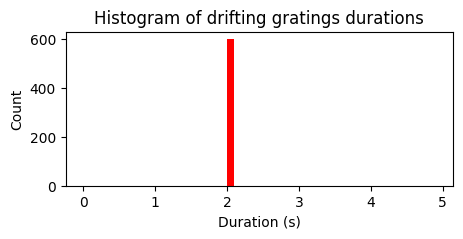

In [9]:
dg_durs = dg_stims['duration'].values # convert to seconds


print('Median duration:',np.median(dg_durs))

fig, ax = plt.subplots(1, 1, figsize=(5, 2))
_ = ax.hist(dg_durs, bins=np.arange(0,5,0.1), color='red') # _ is a throwaway variable to suppress output
ax.set_xlabel('Duration (s)')
ax.set_ylabel('Count')
ax.set_title('Histogram of drifting gratings durations')

Looks like they are all 2 seconds long.

Estimating the inter-trial interval is a bit trickier, since we do not have a column in the dataframe that specifies that. Instead, we need to calculate the times between stimuli.

Median ISI length: 1.0025053479103008


Text(0.5, 1.0, 'Histogram of ISI lengths')

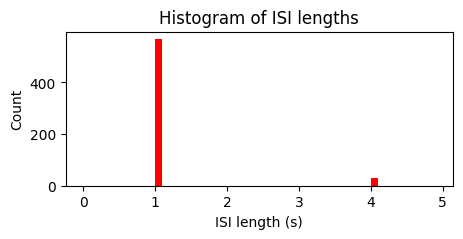

In [10]:
# get the times between stimulus presentation starts
isi_lengths = np.diff(np.sort(dg_times))-2 # subtract 2 seconds to account for the duration of the stimulus

print('Median ISI length:',np.median(isi_lengths))

fig, ax = plt.subplots(1, 1, figsize=(5, 2))
_ = ax.hist(isi_lengths, bins=np.arange(0,5,0.1), color='red')
ax.set_xlabel('ISI length (s)')
ax.set_ylabel('Count')
ax.set_title('Histogram of ISI lengths')

Apart from a few stimuli seperated by ~4 sec, we can rely on stimuli to be separated by at least 1 sec.

## Spiking in response to a stimulus

When a stimulus is presented, some neurons will fire action potentials in response to it. Unless they are primary sensory neurons (e.g. rods and cones in the retina), neurons are responding not directly to the stimulus, but instead to the synaptic drive from other neurons that were also activated by the stimulus. Since neurons in the central nervous system receive synaptic inputs from many sources, not all of which are directly tied to stimulus processing, it is common for them to fire action potentials even when no stimulus is present. This *spontaneous* activity makes the assessment of whether a neuron is stimulus responsive or not a statistical question.

To start answering this question, let's first plot spiking activity of the acceptable single neuron with respect to the presentation of a drifting grating. 

In [11]:
# get the times of the drifting grating with 
# with orientation 0 and temporal frequency 4
stim_times = dg_stims[(dg_stims['orientation']==0)
                      & (dg_stims['temporal_frequency']==4)]['start_time'].values

# get the spike times as a dataframe
spikes = spikes_to_df(sess)

# keep only those rows whose index is in unit_ids
spikes = spikes[spikes.index.isin(unit_ids)]

# window the spikes around an event
def window_spikes(spikes, events, window):
    """
    Windows spike times around each event times
    
    Parameters
    ----------
    spikes : array
        Array of spike times
    events : array
        Array of event times
    window : [float, float]
        Window around the event times, [start, end]
    
    Returns
    -------
    spikes_rel : list
        List of arrays of spike times for relative to each event
    """

    # initialize list to store spike times
    spikes_rel = []
    
    # loop through each event time
    for et in events:
        # get the spike times within the window
        start = et+window[0] # start of the window
        end = et+window[1] # end of the window
        spikes_rel.append(spikes[(spikes > start) & (spikes <= end)] - et)
        
    return spikes_rel


# get the spike times relative to the first stimulus time
window = [-0.5, 2.5] # window 0.5 seconds before and 0.5 seconds after
                     # the end of the stimulus
spikes['spike_times_rel'] = spikes['times'].apply(lambda x: window_spikes(x, stim_times, window))

# print some example windowed spikes
print('Example windowed spikes:')
print(spikes.loc[unit_ids[0],'spike_times_rel'][0])

Example windowed spikes:
[-0.26122034 -0.05502031  1.88787992  2.30064663]


The function `window_spikes` takes in an array of spike times (`spikes`) and returns those that were within the time window (`window`) for each event (`events`). The returned times come as a list, with an entry for each event. The spike times within the window are converted to times relative to the event. Those that happened before the event have negative times, and those after the event have positive times. This can be seen in the example windowed spike times we printed.

It would be difficult to appreciate the reponse of neurons to events if we just looked at lists of these relative spike times. Instead, neuroscientists often visually represent these as *spike rasters*. In a raster plot, each spike time is marked as a vertically oriented line, with its position along the x-axis reflecting the spike time. The trial a spike happened on is reflected on the y-axis. This description will make more sense once you see such a plot. We will create a function that does that now.

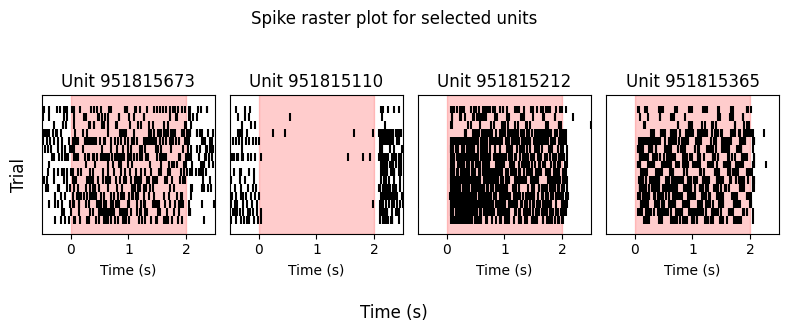

In [12]:
# spike raster plot function
def raster_plot(spikes, ax=None, **kwargs):
    """
    Plots a raster plot of spike times
    
    Parameters
    ----------
    spikes : list
        List of arrays of spike times
    ax : axis, optional
        Axis to plot on
    **kwargs
        Additional keyword arguments to pass to event plot
    """

    # if no axis is provided, create a new one
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 2))
    
    # plot the spikes
    ax.eventplot(spikes, **kwargs)
    ax.set_xlabel('Time (s)')
    ax.set_yticks([])
    ax.set_title('Spike raster plot')

# plot the spike raster
sel_units = unit_ids[[24, 4, 8, 13]]
fig, ax = plt.subplots(1, 4, figsize=(8, 3))
for i, unit in enumerate(sel_units):
    curr_spikes = spikes.loc[unit, 'spike_times_rel']
    raster_plot(curr_spikes, ax[i], color='black')
    ax[i].set_xlim(window)
    # plot shaded region for stimulus window
    ax[i].axvspan(0, 2, alpha=0.2, color='red')
    ax[i].set_title(f'Unit {unit}')
fig.suptitle('Spike raster plot for selected units', y=1.05)
fig.supylabel('Trial')
fig.supxlabel('Time (s)')
fig.tight_layout()


Here we have created raster plots of a few selected neurons in response to a drifting grating with orientation = 0 and temporal frequency = 4 Hz. Each exhibits a distinctive modulation of their spiking. The stimulus occurs during the red shaded region. The first unit does not show an obvious response to the stimulus, while the second unit shows a pronounced suppression of its spiking followed by an increase when the stimulus is turned off. Both the third and fourth units show little spiking outside the stimulus period, but strong spiking activity during the stimulus. The third unit responds continuously to the stimulus (referred to sometimes as *tonic activation*), while the fourth unit exhibits pulsed spiking that may be related to movement in the drifting grating. 

There is a lot of information in this plot, and often we just want to see the mean response of a neuron across all trials. For this, we create a *peri-stimulus time histogram* (PSTH). To calculate this, you measure the time each spike has with respect to when a stimulus was delivered. These are binned, just as we did for calculating firing rate across the recording session last week. Let's create a function to calculate that.

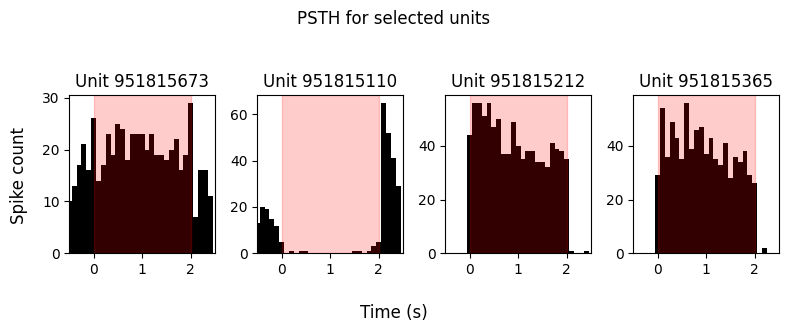

In [13]:
def psth(spikes, bins):
    """
    Computes the PSTH

    Parameters
    ----------
    spikes : list
        List of arrays of spike times
    bins : array
        Array of bin edges

    Returns
    -------
    psth : array
        Array of spike counts
    """

    # initialize list to store spike counts
    psth = np.zeros(len(bins)-1)

    # loop through each spike time array
    for s in spikes:
        # compute the spike counts
        psth += np.histogram(s, bins)[0]

    return psth


# compute the PSTH
bins = np.arange(window[0], window[1]+0.05, 0.1) # 0.1 sec bins
spikes['psth'] = spikes['spike_times_rel'].apply(lambda x: psth(x, bins))

# plot the PSTH for each selected unit
fig, ax = plt.subplots(1, 4, figsize=(8, 3))
for i, unit in enumerate(sel_units):
    curr_psth = spikes.loc[unit, 'psth']
    ax[i].bar(bins[:-1], curr_psth, width=0.1, color='black')
    ax[i].axvspan(0, 2, alpha=0.2, color='red')
    ax[i].set_xlim(window)
    ax[i].set_title(f'Unit {unit}')
fig.suptitle('PSTH for selected units', y=1.05)
fig.supylabel('Spike count')
fig.supxlabel('Time (s)')
fig.tight_layout()


The effct of the stimulus, or lack thereof, is a bit more clear now. However, we have lost information about the variability in spiking across trials. Imagine if a neuron only showed a strong response on a single trial, but not response on the others. We would be less inclined to think of it as reliably encoding the stimulus, even though its PSTH may show a response.

Instead of plotting spikes across time, we could count the number of spikes in response to each stimulus presentation.

## Counting spikes
A point process is one where discrete events happen at specific times. The spiking data we are working with can be tought of as point process since an action potential is a stereotyped event that is defined by the time it occurs. One way t describe a point process is by counting how many events occur during a partiuclar time. In fact, we already did a similar analysis when we generated our PSTHs by binning the relative spike times using the numpy `histogram` function. 

To capture the variability in spiking across stimulus presentations, but not overwhelm with the details of the exact spike times on every trial, we will count the number of spikes on each trial. We can adapt our `window_spikes` function to perform this.

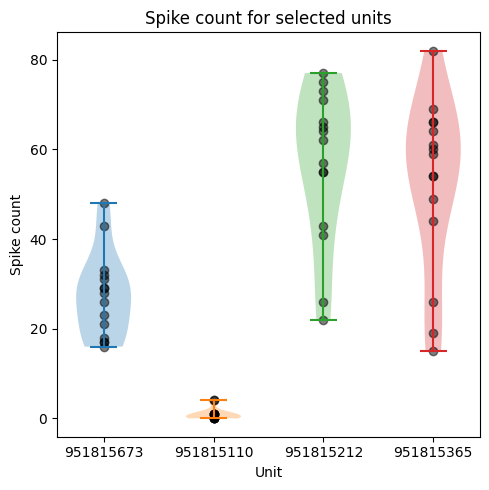

In [14]:
# counts the spikes in a window
def spike_count(spikes, events, window):
    """
    Counts the number of spikes in a window around each events

    Parameters
    ----------
    spikes : array
       Array of spike times
    events : array
        Array of event times
    window : [float, float]
        Window around the event times, [start, end]

    Returns
    -------
    spike_counts : array
        Array of spike counts
    """

    spike_times = window_spikes(spikes, events, window)
    spike_counts = np.array([len(s) for s in spike_times])

    return spike_counts

# compute the spike counts
stim_window = [0, 2] # window encompassing the stimulus presentation
spikes['counts_stim'] = spikes['times'].apply(lambda x: spike_count(x, stim_times, stim_window))

# plot the spike counts for each selected unit
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i, id in enumerate(sel_units):
    curr_counts = spikes.loc[id, 'counts_stim']
    ax.violinplot(curr_counts, positions=[i], widths=0.5)
    ax.scatter(np.ones(len(curr_counts))*i, curr_counts, color='black', alpha=0.5)
ax.set_xticks(np.arange(len(sel_units)))
ax.set_xticklabels(sel_units)
ax.set_xlabel('Unit')
ax.set_ylabel('Spike count')
ax.set_title('Spike count for selected units')
fig.tight_layout()

Here we see that on each trial the number of spikes fired is different. However, by themselves it is difficult to judge whether these counts reflect stimulus driven spiking, or just spontaneous activity. For that, we have to count the number of spikes in a time period when no stimulus was present. The ideal time to measure that is immediately before the delivery of each stimulus, since influences on spiking that are not stimulus-related should be similar to those during stimulus delivery. We will use the 0.5 second period before stimulus delivery for this analysis, since it should be relatively free of spiking driven by the end of the previous stimulus.

Text(0.5, 1.0, 'Spike count for selected units (baseline and stimulus)')

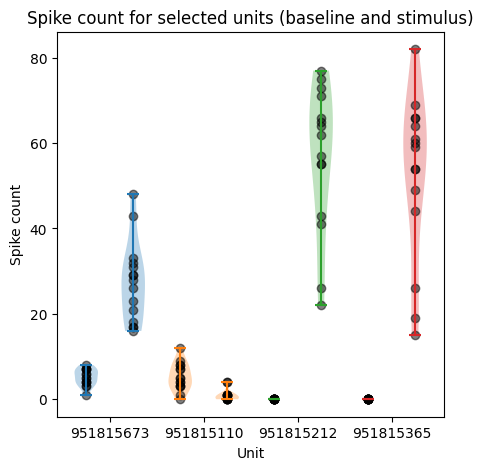

In [15]:
# spike counts during the baseline period
window_base = [-0.5, 0]
spikes['counts_base'] = spikes['times'].apply(lambda x: spike_count(x, stim_times, window_base))

# plot the spike counts and baseline counts for each selected unit
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i, id in enumerate(sel_units):
    curr_counts_base = spikes.loc[id, 'counts_base']
    curr_counts_stim = spikes.loc[id, 'counts_stim']
    ax.violinplot([curr_counts_base, curr_counts_stim], positions=[2*i, (2*i)+1], widths=0.5)
    ax.scatter(2*np.ones(len(curr_counts_base))*i, curr_counts_base, color='black', alpha=0.5)
    ax.scatter((2*np.ones(len(curr_counts_stim))*i)+1, curr_counts_stim, color='black', alpha=0.5)

ax.set_xticks((np.arange(len(sel_units))*2)+0.5)
ax.set_xticklabels(sel_units)
ax.set_xlabel('Unit')
ax.set_ylabel('Spike count')
ax.set_title('Spike count for selected units (baseline and stimulus)')

In this chart each color is a different unit and the first violin plot is the spike count during the baseline period, while the second is the count during the stimulus. The counts are different between the baseline and the stimulus for each unit, but that should not be the case. The first unit did not respond to the stimulus according to the spike raster plot and PSTH, and yet here it shows spike counts during the stimulus that are above the baseline count. 

The reason for this is that our baseline period only counted spikes for 0.5 sec, while the stimulus period has 2 sec. To compensate for this, we should divide the number of spikes by the time we spent measuring them. We can do this for each trial:

Text(0.5, 1.0, 'Firing rate for selected units (baseline and stimulus)')

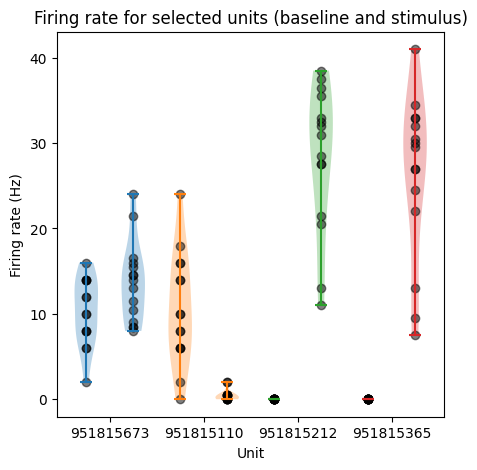

In [16]:
spikes['counts_stim'] = spikes['counts_stim'].apply(lambda x: x/2)
spikes['counts_base'] = spikes['counts_base'].apply(lambda x: x/0.5)

# plot the spike counts and baseline counts for each selected unit
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i, id in enumerate(sel_units):
    curr_counts_base = spikes.loc[id, 'counts_base']
    curr_counts_stim = spikes.loc[id, 'counts_stim']
    ax.violinplot([curr_counts_base, curr_counts_stim], positions=[2*i, (2*i)+1], widths=0.5)
    ax.scatter(2*np.ones(len(curr_counts_base))*i, curr_counts_base, color='black', alpha=0.5)
    ax.scatter((2*np.ones(len(curr_counts_stim))*i)+1, curr_counts_stim, color='black', alpha=0.5)

ax.set_xticks((np.arange(len(sel_units))*2)+0.5)
ax.set_xticklabels(sel_units)
ax.set_xlabel('Unit')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('Firing rate for selected units (baseline and stimulus)')

Note that we have changed the plot labels, from counts to firing rate. This is because our counts have now been divided by the length of time they were taken over, giving them the units counts/sec, which is in Hz. Converting our spike counts to firing rate has given us results that match what we saw earlier.

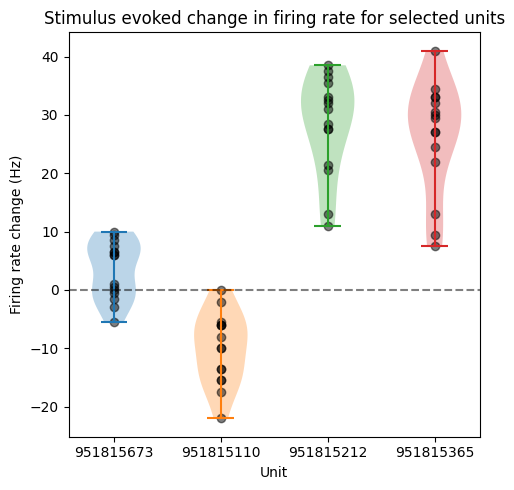

In [17]:
# calculate stimulus evoked change in firing rate
spikes['evoked_change'] = spikes['counts_stim'] - spikes['counts_base']

# plot the stimulus evoked change in firing rate for each selected unit
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i, id in enumerate(sel_units):
    curr_change = spikes.loc[id, 'evoked_change']
    ax.violinplot(curr_change, positions=[i], widths=0.5)
    ax.scatter(np.ones(len(curr_change))*i, curr_change, color='black', alpha=0.5)
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.set_xticks(np.arange(len(sel_units)))
ax.set_xticklabels(sel_units)
ax.set_xlabel('Unit')
ax.set_ylabel('Firing rate change (Hz)')
ax.set_title('Stimulus evoked change in firing rate for selected units')
fig.tight_layout()

After taking the difference in firing rates, it is readily apparent that the first unit has no overall change in firing rate, while the second decreased and the remaining two showed substantial increases.

## Spike counts as a poisson process
While we only observed the neuron's spike count across 15 presentations of the stimulus, it would be helpful to fit a distribution to those counts so we could get the probability of any particular count we observe. Fitting such a distribution requires that we make assumptions about the type of point process that is generating the spikes. It is common in neuroscience to treat spiking as a *poisson process*. There are a couple assumptions built into this. First, it assumes that the occurrence of spikes can be described by their rate. Second, spikes occur indendent from one another. Put another way, the past history of spiking does not influence the probability that a new spike will be produced. We know this to not be the case, since neurons have a refactory period that prevents spikes from occurring within a few milliseconds of one another (if we wanted to incorporate the influence of the previous spike on the probability of the next one, we would treat spiking as a *renewal process*). However, since the refractory period is quite small relative to the few hundred milliseconds that typically separate spikes, usually it can be safely ignored. 

Poisson processes are everywhere in nature, such as the emission of radioactive particles. If we count the number of events in a given interval for a poisson process, it should have the distribution of:

$$ P(\text{Counts}=k) = \frac{\lambda^ke^{-k}}{k!} $$

where $k$ is the number of counts we observed and $\lambda$ is the mean number of counts. This equation gives the probability, $P(...)$, of observing a certain number of counts given the mean number of counts. Using this function, we can calculate the probability distribution for the responses we measured, assuming they are poisson. 

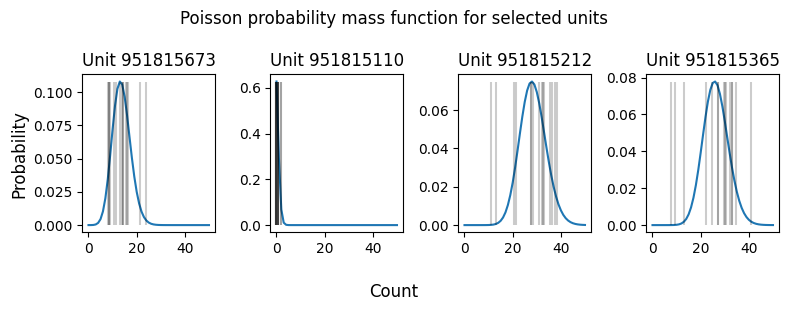

In [18]:
def poisson_pdf(k, lamb):
    """
    Computes the Poisson probability mass function

    Parameters
    ----------
    k : array
        Array of counts
    lamb : float
        Poisson parameter, mean number of counts

    Returns
    -------
    pdf : array
        Array of Poisson probabilities
    """

    # ensure k is an integer
    k = k.astype(int)

    # compute the Poisson probability mass function
    pdf = np.zeros(len(k))
    for i, ki in enumerate(k):
        pdf[i] = ((lamb**ki)*np.exp(-lamb)) / np.math.factorial(ki)

    return pdf

# plot the Poisson probability mass function for each selected unit
fig, ax = plt.subplots(1, 4, figsize=(8, 3))
for i, id in enumerate(sel_units):
    curr_counts = spikes.loc[id, 'counts_stim']
    curr_lambda = np.mean(curr_counts)
    k = np.arange(0, 51)
    pdf = poisson_pdf(k, curr_lambda)
    ax[i].plot(k, pdf)
    ax[i].vlines(curr_counts, 0, pdf.max(), color='black', alpha=0.2)
    ax[i].set_title('Unit {}'.format(id))
fig.suptitle('Poisson probability mass function for selected units')
fig.supylabel('Probability')
fig.supxlabel('Count')
fig.tight_layout()


For the above plots, the blue curve is the estimated probability distribution of spike counts, while the vertical lines are the observed. The poisson distribution seems to reasonably capture the distribution of these points. Since it only depends on the mean count, that is what we will measure from now on. We can always convert between counts and firing rates by dividing counts by the length of time we counted.

## Receptive fields and tuning curves
Thus far we have evaluated a neuron's response to a single type of drifting grating. However, a wide variety were presented, and for good reason. Neurons respond to some types of gratings more than others, often depending on their orientation. Indeed, a hallmark of coding in primary visual cortex is the sensitivity of its neurons to oriented lines, with some neurons responding just to vertically oriented ones, others to horizontal, and the rest to everything in between.

Put more generally, when neurons systematically vary their response to stimuli according to one or more of their parameters, we say they are *tuned*. When an experimenter delivers a series of stimuli that vary along one or more of their properties (e.g. orientation), while measuring the response of a neuron to them, they can construct a *tuning curve* or *receptive field*. For more information about the types of receptive fields throughout the brain, check out my [lecture on it](./supp/RF1Lecture.pdf). If you want to know more about the theory behind constructing receptive fields, I also have a [lecture on that](./supp/RF2Lecture.pdf).

Since the drifting gratings varied in their orientation and temporal frequency, we can evaluate the tuning of neurons to them. To do this, we will construct a generic class for calculating receptive fields that accepts a dataframe of stimulus onset times and spike times for a single neuron, and returns the mean firing rate for each stimulus type.

In [19]:
class rf():
    def __init__(self, stims, window):
        """
        Initializes the class
        
        Parameters
        ----------
        stims : DataFrame
            DataFrame of stimulus presentations
        window : [float, float]
            Window around the event times, [start, end]
        """

        self.window = window
        self.stims = stims
        self.stim_counts = None
    
    def _count_spikes(self, spikes, events):
        """
        Counts spike times around each event time
        
        Parameters
        ----------
        spikes : array
            Array of spike times
        events : array
            Array of event times
        
        Returns
        -------
        counts : array of int
            Spike count in each window around events
        """

        # initialize list to store spike times
        counts = np.zeros(len(events))
        
        # loop through each event time
        for i, et in enumerate(events):
            # get the spike times within the window
            start = et+window[0] # start of the window
            end = et+window[1] # end of the window
            counts[i] = np.sum((spikes > start) & (spikes <= end)) # count the spikes
            
        return counts

    def compute(self, spikes, dims=None):
        """
        Computes the spike counts for each stimulus presentation
        
        Parameters
        ----------
        spikes : array
            Array of spike times
        dims : list of str, optional
            List of dimensions to group stimuli by. If None, all unique stimuli are used
            
        """

        if dims is None:
            # use all unique stimuli
            dims = self.stims.columns
        
        # for each stimulus compute the spike counts
        stim_counts = self.stims.groupby(dims)['start_time'].apply(lambda x: self._count_spikes(spikes, x))
        stim_counts.name = 'spike_counts'
        self.stim_counts = stim_counts.to_frame()
        
        # return object so it can be easily used with apply method in dataframe
        return self

    def rf(self, type='count'):
        """
        Returns the spike counts as an array
        
        Parameters
        ----------
        type : str, optional
            Type of receptive field to return. 
            'count' returns the spike counts
            'rate' returns the firing rate
        
        Returns
        -------
        counts : array
            Array of spike counts
        dims : list of str
            List of dimensions
        vals : list of lists
            List of stimulus values for each dimension
        """

        # get the counts as an array
        counts = self.stim_counts['spike_counts'].apply(np.mean).values

        # get the dimensions
        dims = self.stim_counts.index.names

        # get the values for each dimension
        vals = [self.stim_counts.index.get_level_values(d).unique().values.T for d in dims]

        # reshape the counts to match the stimulus dimension values
        counts = counts.reshape([len(v) for v in vals])

        # compute the firing rate if requested
        if type == 'rate':
            counts = counts / (self.window[1] - self.window[0])
        
        return counts, dims, vals

Our `rf` class generalizes the process of computing receptive fields. Its initialization method accepts a dataframe of stimuli and the desired time window for sampling spiking activity. Analogous to the `fit` method in Scikit-Learn-style estimators, the `compute` method receives an array of spike times and counts the number elicited to each stimulus that shared the same properties specified by the `dims` parameter. It does this by getting the start times for all the similar stimuli, and then counting number of spikes in the windows surrounding those times, using the internal `_count_spikes` method. Now one can invoke the `rf` method to return three variables that describe the receptive field. The first is the mean spike counts (or rate, if specified) across all presentations of each unique stimulus arranged as a multidimensional array, with each dimension corresponding to a different stimulus property. The second is a list of strings with the names of the stimulus properties. Lastly, the values of the stimulus properties are returned as a list of arrays.

Now that we have a class that encapsulates the steps required to compute a receptive field, let's calculate some for the drifting grating stimuli.

### Orientation tuning
Above we analyzed the response of neurons to a single drifting grating and found that they differed in the strength of their response. But, this did not tell us whether individual neurons preferentially responded to certain orientations. To answer this question, we need to measure a neuron's response to drifting gratings with different orientations.

Let's use our `rf` class to do this for one neuron.

Text(0.5, 1.0, 'Tuning curve for unit 951815599')

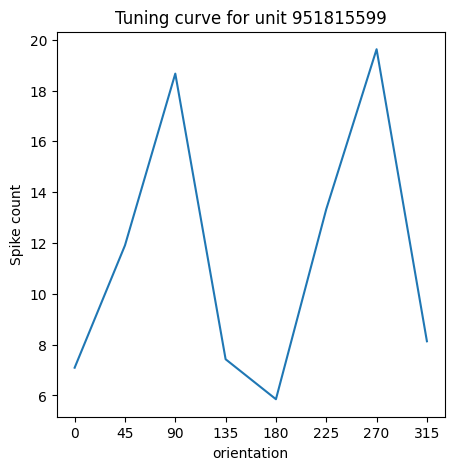

In [20]:
# initialize the rf object with drifting grating stimuli 
# and a 2 second window, since the stimulus duration is 2 seconds
rf_dg = rf(dg_stims, [0, 2])

# compute the total spike counts for each orientation
rf_dg.compute(spikes=spikes.loc[unit_ids[19],'times'],dims=['orientation'])

# get the orientation receptive field measured in spike counts
count, dims, vals = rf_dg.rf()

# plot the tuning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(vals[0], count)
ax.set_xlabel(dims[0])
ax.set_xticks(vals[0])
ax.set_ylabel('Spike count')
ax.set_title('Tuning curve for unit {}'.format(unit_ids[19]))


Here we see that the neuron responds preferentially to drifting gratings oriented at 90 and 270 degrees. This double peaked tuning curve is typical of neurons in primary visual cortex. If a neuron responds to lines moving in one direction, ofte they will also respond to lines moving in the opposite direction. However, this is not always the case. Sometimes one direction is preferred over another. For instance:

Text(0.5, 1.0, 'Tuning curve for unit 951815237')

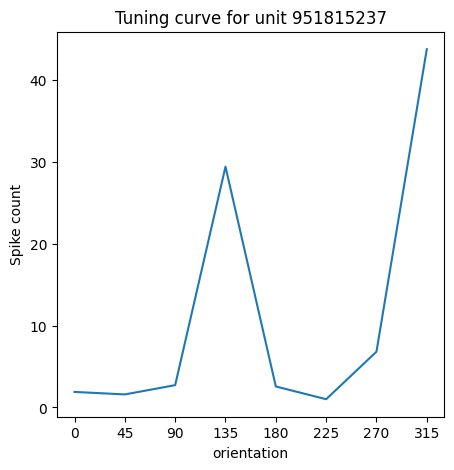

In [21]:
# compute the total spike counts for each orientation
rf_dg.compute(spikes=spikes.loc[unit_ids[10],'times'],dims=['orientation'])

# get the orientation receptive field measured in spike counts
count, dims, vals = rf_dg.rf()

# plot the tuning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(vals[0], count)
ax.set_xlabel(dims[0])
ax.set_xticks(vals[0])
ax.set_ylabel('Spike count')
ax.set_title('Tuning curve for unit {}'.format(unit_ids[10]))

This neuron has a strong response to gratings drifting at 315 degrees, and a weaker response to those drifting in the opposite direction at 135 degrees (315-180 = 135). This direction related asymmetry in the evoked spiking will be exploited next week to train decoders that can discriminate across all 360 degrees.

We could visually evaluate the tuning curve of each neuron and determine their properties, but it would be far better to have an automated procedure for extracting the properties of each tuning curve. We would also want a way to measure of whether a tuning curve was even present. We achieve both goals by using the `curve_fit` function in SciPy.

The `curve_fit` function accepts 
If we want to extract the properties of the tuning curve, one can create a mathematical formula that describes it and then use the parameters of that formula to infer the properties of the tuning curve. For orientation tuning in primary visual cortex, it was found that two gaussians with an imposed 180 degrees between them and the potential for different peak amplitudes was sufficient. This equation was described in Carandini and Ferster 2000:

$$ response = r_0 + r_p e^{-\frac{(ori-ori_{pref})^2}{2SD^2}} 
                  + r_n e^{-\frac{(ori - ori_{pref}-180)^2}{2SD^2}}
$$

Here the first term, $r_0$, is the baseline spike count common across all orientations. The second term describes the bump in the tuning curve between 0 and 180 degrees, while the third term describes the other bump between 180 and 360 degrees. If we transform this equation into a function and include arguments for each of the free parameters ($r_0$, $ori_{pref}$, etc), we can fit it to each tuning curve using `curve_fit` and summarize their properties. Moreover, the quality of the fit indicates the degree to which our neuron is tuned. The first output argument of `curve_fit` is the optimized parameters. These will tell us:

1. $ori_{pref}$: the orientation tuning 
2. $\frac{\left|r_p-r_n\right|}{r_p+r_n+2r_0}$: known as the direction index, measures asymmetry in the response. A 0 means there is no asymmetry, while a 1 suggests that only a single peak is present.
3. $SD$: we will call this the orientation selectivity, which measures the spread of the orientation tuning. A broader tuning has a larger $SD$.

In [22]:
def curve_func(x, r0, rp, rn, op, sd):
    """
    Computes the orientation tuning curve
    Based on Carandini and Ferster, 2000

    Parameters
    ----------
    x : array
        Array of orientation values
    r0 : float
        baseline firing rate
    rp : float
        preferred orientation firing rate
    rn : float
        null orientation firing rate
    op : float
        orientation preference
    sd : float
        tuning width

    Returns
    -------
    y : array
        Array of firing rates
    """

    # x values are in degrees, convert to range -180 to 180
    deg_rng = lambda deg: np.mod(deg, 360) - 180
    
    # compute the tuning curve
    y = r0 + (rp * np.exp(-(deg_rng(x - op)**2) / (2*sd**2))) \
           + (rn * np.exp(-(deg_rng(x - (op + 180))**2) / (2*sd**2)))

    return y

Let's test how well this function fits the two neurons whose tuning curves we inspected before. 

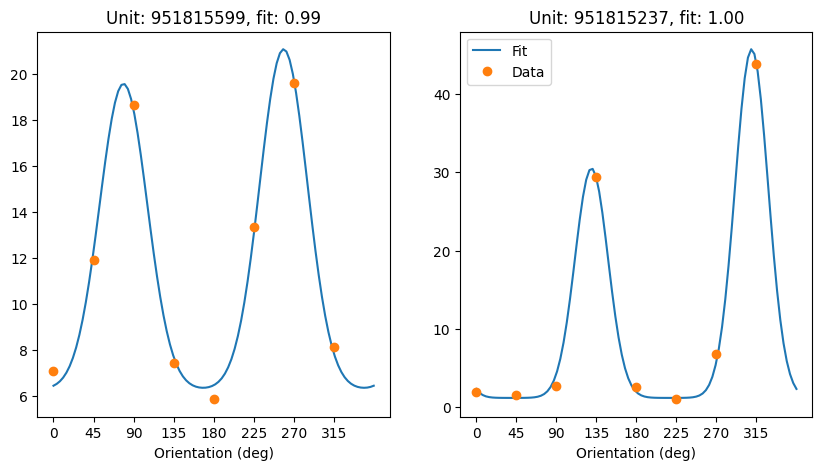

In [23]:
ori = np.linspace(0, 360, 100)
fig, ax = plt.subplots(1,2, figsize=(10, 5))
for i, id in enumerate(unit_ids[[19, 10]]):

    # compute the spike counts for each orientation
    rf_dg.compute(spikes=spikes.loc[id,'times'],dims=['orientation'])
    count, dims, vals = rf_dg.rf()

    # fit the tuning curve
    popt, _ = curve_fit(curve_func, vals[0], count, bounds=([0, 0, 0, 0, 0], [20, 80, 80, 360, 180]))

    # compute the match between the data and the fitted curve
    fit_rsq = np.corrcoef(count, curve_func(vals[0], *popt))[0,1]**2

    ax[i].plot(ori, curve_func(ori, *popt), label='Fit')
    ax[i].plot(vals[0], count, 'o', label='Data')
    ax[i].set_xlabel('Orientation (deg)')
    ax[i].set_xticks(vals[0])
    ax[i].set_title('Unit: {}, fit: {:.2f}'.format(id, fit_rsq))
ax[-1].legend()

For each neuron we calculated the orientation tuning curve, fitted our characteristic curve to it, and then evaluated fit quality by measuring the coefficient of determination, $R^2$. This is a measure of the degree to which the observed values can be predicted by the fitted curve. If that prediction is perfect, then $R^2$ is equal to 1, otherwise it approaches 0 as the relation between the two approaches completely random. Note that a coefficient of determination equal to 1 does **not** mean that the observed data points lie exactly on the fitted curve, just that they exactly covary with the fitted curve (as described by a line, y=ax+b). The mean squared error, which we talked about several weeks back, measures the distance between the fitted curve and the observed data. But, because its value ranges from 0 to infinity, it is difficult to compare between neurons.

Taking everything we just did, we can create a function that will fit an orientation tuning curve and return the properties of the tuning curve and its quality of fit.

In [24]:
# fit curve to example
def fit_ori(ori, count):
    """
    Fits the orientation tuning curve to the data

    Parameters
    ----------
    ori : array
        Array of orientation values
    count : array
        Array of spike counts

    Returns
    -------
    popt : array
        Array of optimal parameters
    rsq : float
        R^2 value of the fit
    """


    # fit the curve
    popt, _ = curve_fit(curve_func, ori, count, 
                        bounds=([0, 0, 0, 0, 0], [20, 80, 80, 360, 90]))
    
    # compute the R^2 value
    rsq = np.corrcoef(count, curve_func(ori, *popt))[0,1]**2

    return popt, rsq

With the `rf` class and `fit_ori` function, we can take our dataframe of spiking data and get the orientation tuning curve properties for every neuron.

In [25]:
# compute RF for each unit
spikes['rf'] = spikes['times'].apply(lambda x: rf(dg_stims, [0, 2]).compute(x, dims=['orientation']))

# get the empirical orientation tuning curve
spikes['rf_ori_emp'] = spikes['rf'].apply(lambda x: x.rf())

# fit the orientation tuning curve for each unit
spikes['rf_ori_fit'] = spikes['rf_ori_emp'].apply(lambda x: fit_ori(x[2][0], x[0]))

# unpack the fit parameters and R^2 value
spikes[['rf_ori_fit_props', 'rf_ori_fit_rsq']] = pd.DataFrame(spikes['rf_ori_fit'].tolist(), index=spikes.index)


Now that we have the orientation tuning properties of every neuron, we can look at their distribution to determine how orientations are coded for at the *population* level. This is a term you will run into often when decoding from spiking activity. Because each neuron (or cluster of units in a multi-unit) responds to distinct sets of events, their activities can be passed to a multifeature classifier to provide robust decoding. This is similar to what we did with spectral decoding of ECoG data. 

If we want to build a decoder of orientation from this single neuron activity, this will depend on whether their preferred orientations span the entire range, 0-360 degrees. Orientations not coded by any neurons will be difficult to decode. Morevoer, because orientation tuning curves are double peaked, if both peaks have the same amplitude they will not uniquely encode a single orientation. If all the neurons were perfectly symmetric, then it would be impossible to train a classifier that differentiates between orientations from 0-180 and 180-360 degrees. Eg. a symmetric neuron with a preferred orientation at 90 will equally respond to 90+180=270 degrees. 

But before we can evaluate this, we need to determine what proportion of neurons exhibit orientation tuning. The curve fit parameters from an untuned neuron would be uniformative for decoding, so we want to remove those from our population analysis. This requires us to set a threshold for determining if a neuron is sufficiently tuned. To decide on that threshold, we will plot the distribution of the fit, $R^2$.

Text(0.5, 1.0, 'Histogram of $R^2$ values for orientation tuning curve fits')

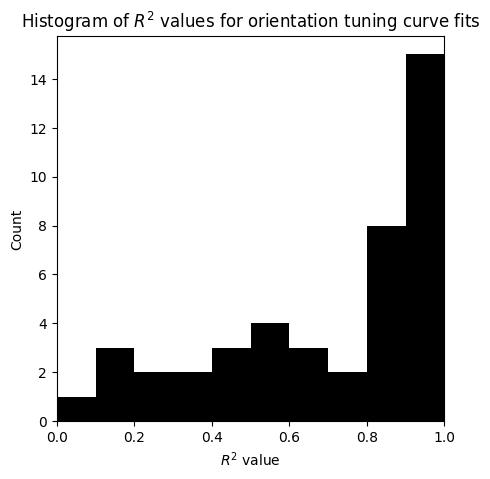

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(spikes['rf_ori_fit_rsq'], bins=np.arange(0, 1.1, 0.1), color='black')
ax.set_xlabel('$R^2$ value')
ax.set_ylabel('Count')
ax.set_xlim([0, 1])
ax.set_title('Histogram of $R^2$ values for orientation tuning curve fits')

The distribution of $R^2$ values appears to have two components. One is a tight distribution of high $R^2$ values clustered above 0.8, while the other is a broadly distributed over the full range of values. We would expect those clustered on the high end have good orientation tuning, while those below do not. While we could draw the by eye cutoff at 0.8, a more principled approach is to fit two gaussians to this distribution and find the point where they cross-over. The Scikit-Learn package provides an estimator for that, `GaussianMixture`. It tries to fit multiple gaussian curves to a data distribution. We will not delve deeply into how this works here, but just apply it as a way to set our threshold for declaring a neuron orientation tuned. That threshold will be set to where the probability of an $R^2$ value goes from more likely to be part of the broadly untuned distribution to the high tuned end. Let's apply that.

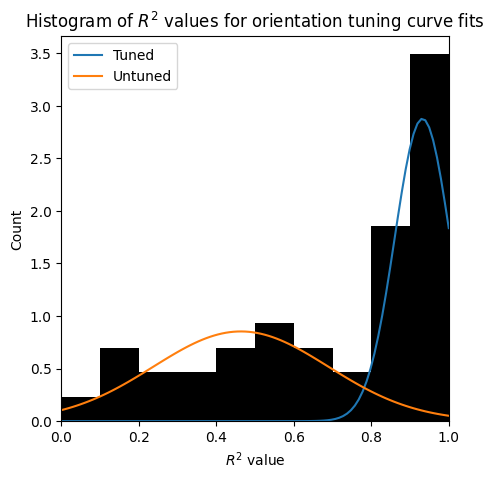

In [31]:
# initialize the GMM
gmm = GaussianMixture(n_components=2, random_state=47)

# fit the GMM to the R^2 values
gmm.fit(spikes['rf_ori_fit_rsq'].values.reshape(-1, 1))

# get the means and covariances
means = gmm.means_.flatten()
covs = gmm.covariances_.flatten()

# plot the histogram with the GMM fit
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(spikes['rf_ori_fit_rsq'], bins=np.arange(0, 1.1, 0.1), density=True, color='black')
ax.set_xlabel('$R^2$ value')
ax.set_ylabel('Count')
ax.set_xlim([0, 1])
ax.set_title('Histogram of $R^2$ values for orientation tuning curve fits')
x = np.linspace(0, 1, 100)
ax.plot(x, gmm.weights_[0]*norm.pdf(x, means[0], np.sqrt(covs[0])), label='Tuned')
ax.plot(x, gmm.weights_[1]*norm.pdf(x, means[1], np.sqrt(covs[1])), label='Untuned')
ax.legend()

Here we got two components that match our intuition about there being a narrow, tuned, distribution on the high end (blue) and a broad untuned distribution (orange). Just below $R^2=0.8$ the distributions cross-over. This is where the threshold should be for declaring a unit tuned. To find that numerically, we can subtract the Tuned curve from the Untuned curve and find the point where that difference goes from positive to negative.

In [36]:
# get tuned and untuned curves
x = np.linspace(0, 1, 100)
tuned_curve = gmm.weights_[0]*norm.pdf(x, means[0], np.sqrt(covs[0]))
untuned_curve = gmm.weights_[1]*norm.pdf(x, means[1], np.sqrt(covs[1]))

# get difference between tuned and untuned curves
diff = untuned_curve - tuned_curve

# get the threshold
thresh = x[np.nonzero(diff < 0)[0][0]]

print("Threshold for tuned R^2: {:.2f}".format(thresh))

Threshold for tuned R^2: 0.79


Now that we have the threshold, we can plot the distribution of the orientation tuning properties for those neurons that showed actual tuning.

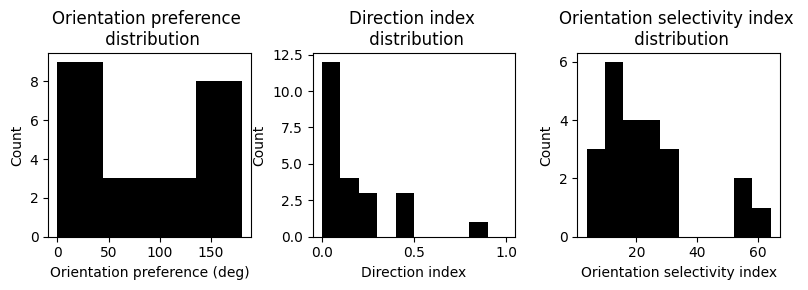

In [46]:
# classify the units as tuned or untuned
spikes['tuned'] = spikes['rf_ori_fit_rsq'] > thresh

# extract the orientation preference, 0-180
spikes['ori_pref'] = spikes['rf_ori_fit_props'].apply(lambda x: np.mod(x[3],180))

# direction index
dir_func = lambda r0, rp, rn: np.abs(rp - rn) / (rp + rn + (2*r0))
spikes['dir_index'] = spikes['rf_ori_fit_props'].apply(lambda x: dir_func(*x[0:3]))

# orientation selectivity index
spikes['ori_index'] = spikes['rf_ori_fit_props'].apply(lambda x: x[4])

# create a new dataframe with only the tuned units
tuned = spikes[spikes['tuned']]

# plot the distribution of each property
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].hist(tuned['ori_pref'], bins=np.arange(0, 181, 45), color='black')
ax[0].set_xlabel('Orientation preference (deg)')
ax[0].set_ylabel('Count')
ax[0].set_title('Orientation preference \n distribution')
ax[1].hist(tuned['dir_index'], bins=np.arange(0, 1.1, 0.1), color='black')
ax[1].set_xlabel('Direction index')
ax[1].set_ylabel('Count')
ax[1].set_title('Direction index \n distribution')
ax[2].hist(tuned['ori_index'], color='black')
ax[2].set_xlabel('Orientation selectivity index (deg)')
ax[2].set_ylabel('Count')
ax[2].set_title('Orientation selectivity index \n distribution')
fig.tight_layout()


Fortunately our tuned units span the entire range of orientations, with an overrepresentation at 0 and 180, which are the same orientation but going in opposite directions (gratings moving either to the right or left). The direction index is clustered around 0, suggesting that a plurality of neurons show symmetric tuning. However, there were still several units with a direction index greater than 0.2, which may be sufficient to adequetly sample the entire 0-360 degrees of orientations. Lastly, the orientation selectivity index values were almost all below 45 degrees. These tight distributions mean tuning curves will precisely code just two orientations, X and X+180. Assuming neurons respond reliably to the orientations that drives them, we should be able to accurately decode. However, if they do not then orientations with only 3 neurons coding for them will exhibit impaired decoding. Next week we will determine the degree to which this is a problem.

### Temporal frequency

In [27]:

# compute RF for each unit
spikes['rf'] = spikes['times'].apply(lambda x: rf(dg_stims, [0, 2]).compute(x, dims=['temporal_frequency']))
spikes['rf_tf_emp'] = spikes['rf'].apply(lambda x: x.rf())


# fit the orientation tuning curve for each unit
#spikes['rf_ori_fit'] = spikes['rf_ori_emp'].apply(lambda x: fit_ori(x[2][0], x[0]))
#spikes[['rf_ori_fit_props', 'rf_ori_fit_rsq']] = pd.DataFrame(spikes['rf_ori_fit'].tolist(), index=spikes.index)

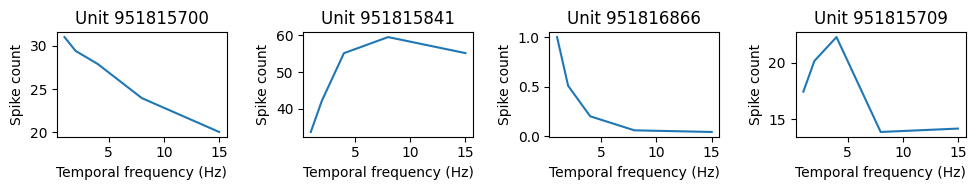

In [28]:
sel_units = unit_ids[[27,31,34,26]]
fig, ax = plt.subplots(1,4,figsize=(10,2))
for i, id in enumerate(sel_units):
    ax[i].plot(spikes.loc[id,'rf_tf_emp'][2][0], spikes.loc[id,'rf_tf_emp'][0])
    ax[i].set_xlabel('Temporal frequency (Hz)')
    ax[i].set_ylabel('Spike count')
    ax[i].set_title(f'Unit {id}')
fig.tight_layout()


### Orientation and Temporal Frequency 

In [29]:
# compute RF for each unit
spikes['rf'] = spikes['times'].apply(lambda x: rf(dg_stims, [0, 2]).compute(x, dims=[ 'temporal_frequency','orientation']))
spikes['rf_oritf_emp'] = spikes['rf'].apply(lambda x: x.rf())


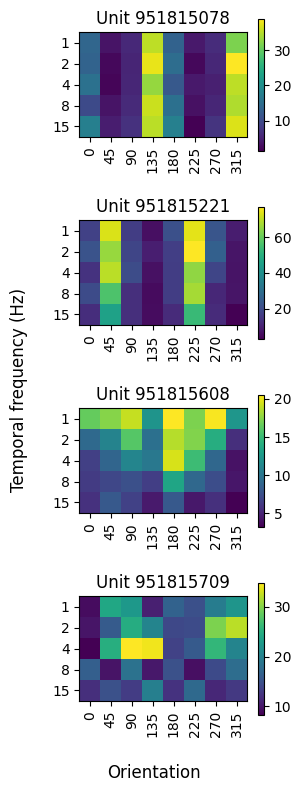

In [31]:
sel_units = unit_ids[[1,7,18,32]] #11,16,18+,32
fig, ax = plt.subplots(4,1,figsize=(3,8))
for i, id in enumerate(sel_units):
    counts, dims, vals = spikes.loc[id,'rf_oritf_emp']
    im = ax[i].imshow(counts)
    cbar = fig.colorbar(im, ax=ax[i])
    ax[i].set_yticks(np.arange(len(vals[0])))
    ax[i].set_yticklabels(vals[0].astype(int))
    ax[i].set_xticks(np.arange(len(vals[1])))
    ax[i].set_xticklabels(vals[1].astype(int), rotation=90)
    ax[i].set_title(f'Unit {id}')
fig.supylabel('Temporal frequency (Hz)')
fig.supxlabel('Orientation')
fig.tight_layout()

In [38]:
gab_stims = stims[stims['stimulus_name']=='gabors']
gab_stims

,stimulus_block,start_time,stop_time,temporal_frequency,color,frame,size,stimulus_name,contrast,orientation,spatial_frequency,x_position,phase,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
1,0.0,84.410468,84.643989,4.0,null,null,"[20.0, 20.0]",gabors,0.8,90.0,0.08,0.0,"[3644.93333333, 3644.93333333]",20.0,0.233521,1
2,0.0,84.643989,84.894190,4.0,null,null,"[20.0, 20.0]",gabors,0.8,90.0,0.08,20.0,"[3644.93333333, 3644.93333333]",-10.0,0.250201,2
3,0.0,84.894190,85.144391,4.0,null,null,"[20.0, 20.0]",gabors,0.8,45.0,0.08,-30.0,"[3644.93333333, 3644.93333333]",-10.0,0.250201,3
4,0.0,85.144391,85.394592,4.0,null,null,"[20.0, 20.0]",gabors,0.8,0.0,0.08,40.0,"[3644.93333333, 3644.93333333]",30.0,0.250201,4
5,0.0,85.394592,85.644819,4.0,null,null,"[20.0, 20.0]",gabors,0.8,90.0,0.08,0.0,"[3644.93333333, 3644.93333333]",0.0,0.250226,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3641,0.0,995.154498,995.404699,4.0,null,null,"[20.0, 20.0]",gabors,0.8,0.0,0.08,40.0,"[3644.93333333, 3644.93333333]",40.0,0.250201,204
3642,0.0,995.404699,995.654900,4.0,null,null,"[20.0, 20.0]",gabors,0.8,45.0,0.08,0.0,"[3644.93333333, 3644.93333333]",-40.0,0.250201,234
3643,0.0,995.654900,995.905101,4.0,null,null,"[20.0, 20.0]",gabors,0.8,90.0,0.08,30.0,"[3644.93333333, 3644.93333333]",-10.0,0.250201,88


In [39]:
# compute RF for each unit
spikes['rf'] = spikes['times'].apply(lambda x: rf(gab_stims, [0, 0.2]).compute(x, dims=[ 'orientation', 'x_position', 'y_position']))
spikes['rf_gab_emp'] = spikes['rf'].apply(lambda x: x.rf())

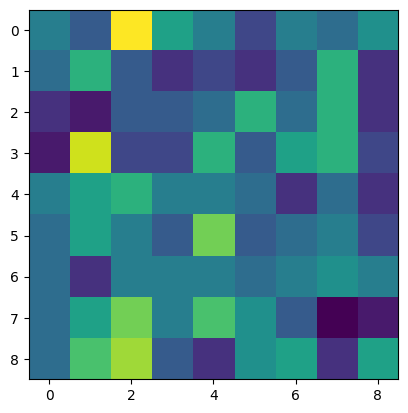

In [79]:
rf_gab, dims, vals = spikes.loc[unit_ids[42],'rf_gab_emp']
plt.imshow(np.mean(rf_gab, axis=0))

## Noise correlation